<a href="https://colab.research.google.com/github/asadali163/Time-Series-Experiments/blob/main/codebase/ESMA_and_Holt_Winters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O airline.csv https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-09 11:36:40--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline.csv’

airline.csv         100%[===================>]   1.99K  --.-KB/s    in 0s      

2024-07-09 11:36:40 (21.8 MB/s) - ‘airline.csv’ saved [2036/2036]



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [ ]:
df = pd.read_csv('airline.csv', index_col="Month", parse_dates=True)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
df.isna().sum()

Passengers    0
dtype: int64

<Axes: xlabel='Month'>

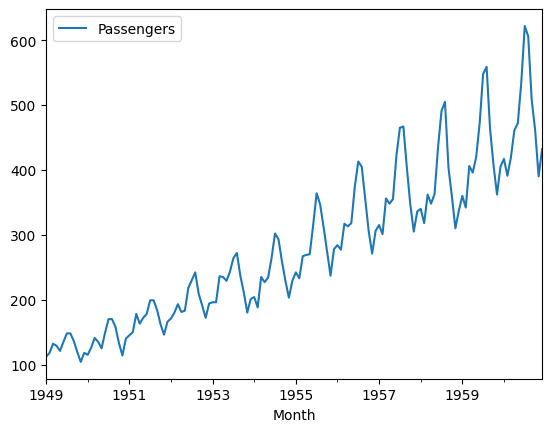

In [ ]:
df.plot()

<Axes: xlabel='Month'>

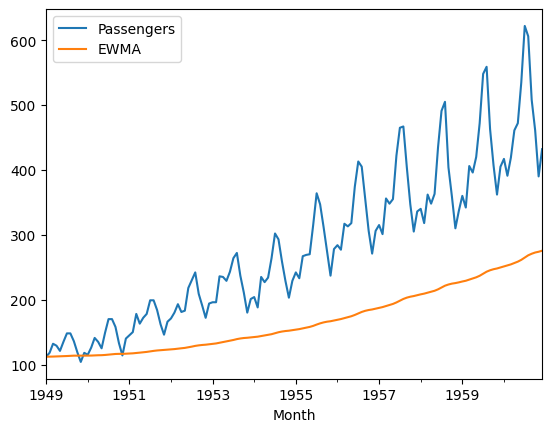

In [ ]:
alpha = 0.01
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()
df.plot()

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [ ]:
df.index.freq = 'MS'

In [ ]:
N_test = 12
df_train = df[:-N_test]
df_test = df[-N_test:]

In [ ]:
ses = SimpleExpSmoothing(df_train['Passengers'], initialization_method='legacy-heuristic')

In [ ]:
res = ses.fit()

In [ ]:
train_idx = df.index <= df_train.index[-1]
test_idx = df.index > df_train.index[-1]

<Axes: xlabel='Month'>

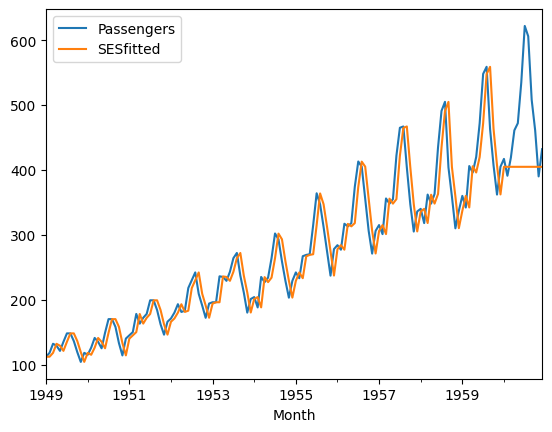

In [ ]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers','SESfitted']].plot()

In [ ]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

### Now we will works with Holt Linear Trend Model

In [ ]:
from statsmodels.tsa.holtwinters import Holt

In [ ]:
holt = Holt(df['Passengers'], initialization_method='legacy-heuristic')
res = holt.fit()
df['Holt-1'] = res.fittedvalues

<Axes: xlabel='Month'>

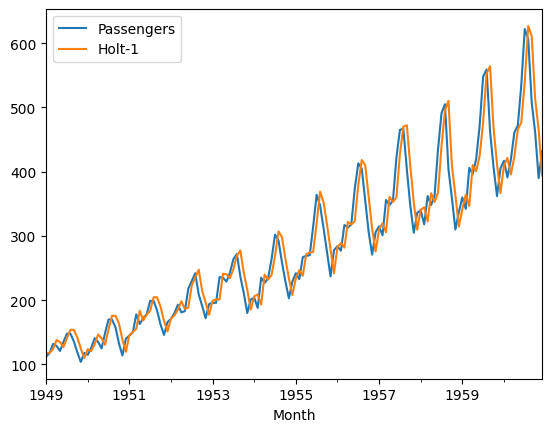

In [ ]:
df[['Passengers','Holt-1']].plot()

##### Now we will do with train and test set

<Axes: xlabel='Month'>

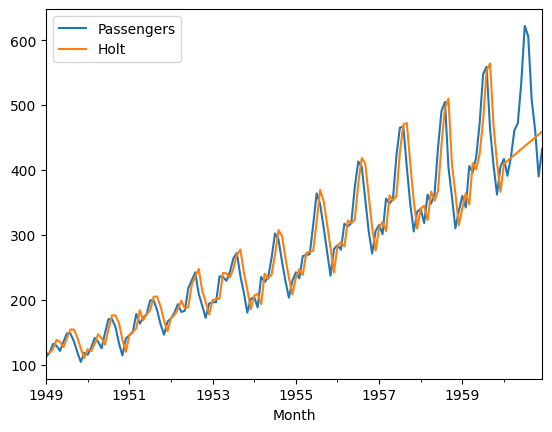

In [ ]:
holt_t = Holt(df_train['Passengers'], initialization_method='legacy-heuristic')
res_t = holt_t.fit()
df.loc[train_idx, 'Holt'] = res_t.fittedvalues
df.loc[test_idx, 'Holt'] = res_t.forecast(N_test)
df[['Passengers','Holt']].plot()

### Now we will work on Holt Winter Model which combine level, trend, and seasonality

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
h_w = ExponentialSmoothing(df_train['Passengers'], trend='add', seasonal='add', seasonal_periods=12)
res = h_w.fit()

<Axes: xlabel='Month'>

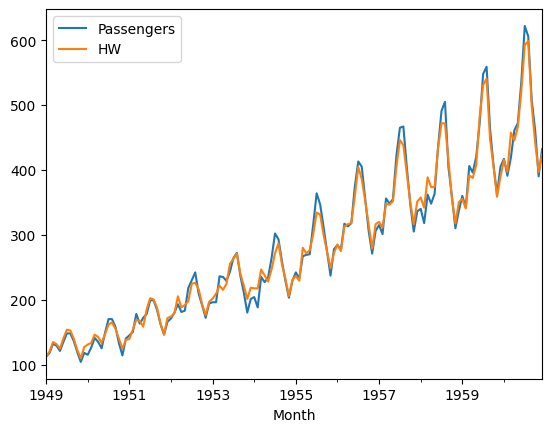

In [ ]:
df.loc[train_idx, 'HW'] = res.fittedvalues
df.loc[test_idx, 'HW'] = res.forecast(N_test)
df[['Passengers','HW']].plot()

As there can be different values for treand and seasonality (add and mul), so we should use different parameters to check which one works better

### Now we will work with Walk Forward Validation for time series data

In [ ]:
df.head()

,Passengers,EWMA,SESfitted,Holt-1,Holt,HW
Month,,,,,,
1949-01-01,112,112.000000,112.000000,118.000000,118.000000,112.004998
1949-02-01,118,112.060000,112.000000,118.007089,117.985093,120.135872
1949-03-01,132,112.259400,117.970000,123.977209,123.977513,134.654355
1949-04-01,129,112.426806,131.929850,137.967695,137.997464,131.334969
1949-05-01,121,112.512538,129.014649,135.018254,134.985294,124.583454


In [ ]:
df.shape

(144, 6)

In [ ]:
## Set forecast horizon value h = 12, and walk forward validation step = 10
h = 12
steps = 10
Ntest = len(df) - h - steps + 1

In [ ]:
# Configuration hyperparameters to try
trend_type_list = ['add', 'mul']
seasonal_type_list = ['add', 'mul']
damped_trend_list = [True, False]
init_method_list  = ['estimated', 'heuristic', 'legacy-heuristic']
use_boxcox_list = [True, False, 0]